# Automated Pneumonia Diagnosis based on Chest X-ray Images
The author of this notebook is **Dr Raheel Siddiqi**. He is a Senior Assistant Professor at *Bahria University, Karachi Campus*. His research interests include Computer Vision and Deep Learning.

The objective of the experiment (presented in this notebook) is to evaluate the performance of a self-designed *Convolutional Neral Network (CNN)* when employed to diagnose Pneumonia. The diagnosis process comprises of classifying Chest X-ray images into one of the two classes: (a) Normal, (b) Pneumonia. 

The dataset is downloded from [kaggle.com](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The dataset contains 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 

First of all we import all the relevant packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

%matplotlib inline

Here all the pneumonia and normal x-ray image file names are retrieved and stored in two variables.

In [2]:
total_images_train_normal = os.listdir('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\NORMAL')
total_images_train_pneumonia = os.listdir('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\PNEUMONIA')

Some normal x-ray images are displayed.

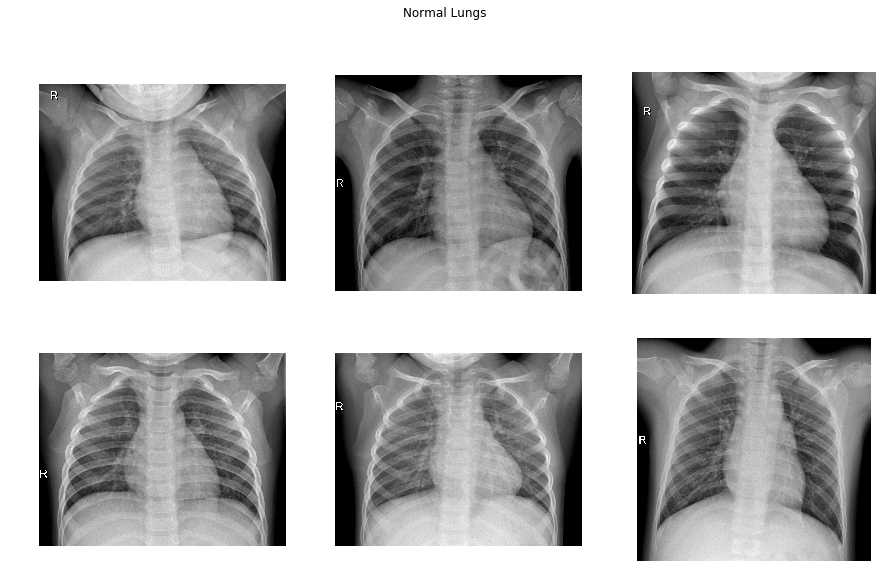

In [3]:
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\NORMAL\\'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

Some Pneumonia X-ray images are displayed below.

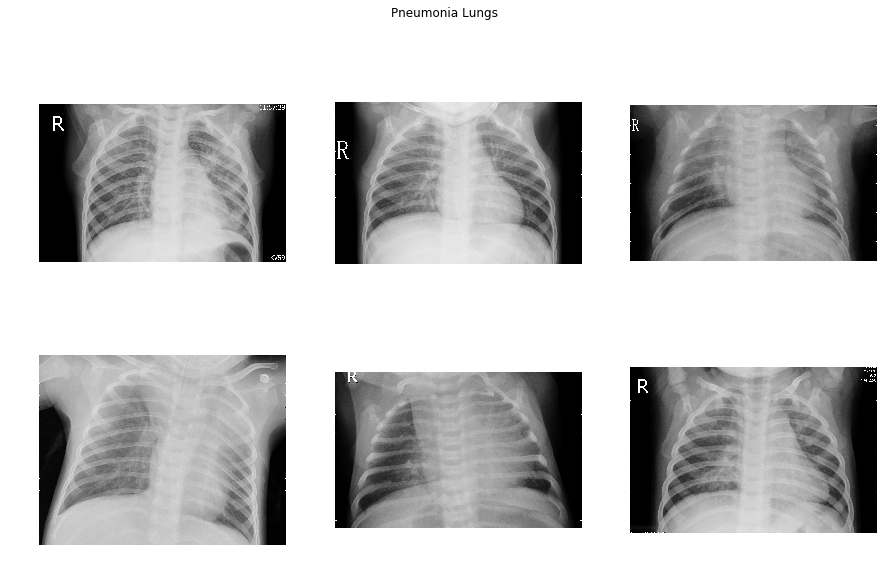

In [4]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\PNEUMONIA\\'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

Now we compare and visualize the difference in the number of the two types of x-ray images.

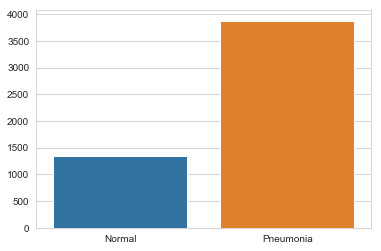

In [5]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])

### Model Creation and Compilation
Here we declare some variables for our convenience.

In [6]:
image_height = 150
image_width = 150
batch_size = 10
no_of_epochs  = 30

Here a sequential model is created and compiled.

In [7]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Here we view the details of the model that we have just created.

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0         
__________

Here we set our parameters for data augmentation.

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

Batches of training and testing data are read and stored in `training_set` and `test_set` variables, respectively. Training set consists of `5216` images, while test set consists of `624` images.

In [10]:
training_set = train_datagen.flow_from_directory('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')

test_set = test_datagen.flow_from_directory('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Setting up a callback so that *learning rate* may be reduced if learning becomes stagnant during training.

In [11]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

### Training of Model

The training phase comprises of 30 epochs.

In [12]:
history = model.fit_generator(training_set,
                    steps_per_epoch=5216//batch_size,
                    epochs=no_of_epochs,
                    validation_data=test_set,
                    validation_steps=624//batch_size,
                    callbacks=callbacks
                   )

Epoch 1/30
521/521 [==============================] - 594s 1s/step - loss: 0.4554 - acc: 0.8006 - val_loss: 0.4462 - val_acc: 0.7613
Epoch 2/30
521/521 [==============================] - 559s 1s/step - loss: 0.3241 - acc: 0.8567 - val_loss: 0.5215 - val_acc: 0.7710
Epoch 3/30
521/521 [==============================] - 555s 1s/step - loss: 0.2901 - acc: 0.8747 - val_loss: 0.4551 - val_acc: 0.7387
Epoch 4/30
521/521 [==============================] - 553s 1s/step - loss: 0.2602 - acc: 0.8954 - val_loss: 0.3725 - val_acc: 0.8371
Epoch 5/30
521/521 [==============================] - 552s 1s/step - loss: 0.2277 - acc: 0.9107 - val_loss: 0.3773 - val_acc: 0.8355
Epoch 6/30
521/521 [==============================] - 553s 1s/step - loss: 0.2124 - acc: 0.9180 - val_loss: 0.4556 - val_acc: 0.8323
Epoch 7/30
521/521 [==============================] - 658s 1s/step - loss: 0.1856 - acc: 0.9273 - val_loss: 0.4518 - val_acc: 0.8548
Epoch 8/30
521/521 [==============================] - 570s 1s/step - 

### Visualization of Training and Validation Process
The following part of the code visualizes how the training and validation losses and accuracies evolved with the number of epochs.

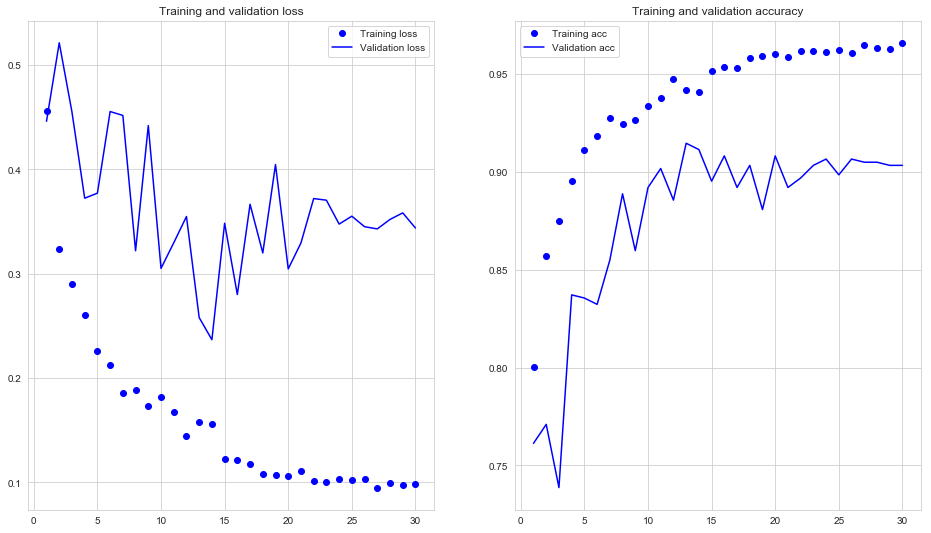

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(16,9))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### Computing the Final Test-Set Classification Accuracy
Here we calculate our trained model's final classification accuracy.

In [14]:
no_steps = len(test_set)
result = model.evaluate_generator(test_set, steps=no_steps)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 90.38%


### Calculating Precision and Recall values for the model
*Precision-Recall* is a useful measure of success of prediction when the classes are very imbalanced. High *precision* relates to a low false positive rate, and high *recall* relates to a low false negative rate. 

**Precision** is defined as the number of true positives over the number of true positives plus the number of false positives. **Recall** is defined as the number of true positives over the number of true positives plus the number of false negatives. Please see the [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) for details. 

But first we prepare our test data, so that later we can draw the confusion matrix as well as calculate precision and recall of the model.

In [49]:
# Preparing test data
import glob
from pathlib import Path
from tensorflow.python.keras.utils import to_categorical

normal_cases_dir = Path('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\NORMAL')
pneumonia_cases_dir = Path('C:\\Users\\Raheel Siddiqi\\Pneumonia_Diagnosis_using_Chest_X_Ray\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\PNEUMONIA')

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 150, 150, 3)
Total number of labels: (624, 1)


In [50]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 17s 28ms/step
Loss on test set:  0.33858482585324406
Accuracy on test set:  0.9038461538461539


In [51]:
# Get predictions
preds = model.predict(test_data, batch_size=16,verbose=1)
preds=np.around(preds)
orig_test_labels=test_labels
print(preds.shape)
print(orig_test_labels.shape)

624/624 [==============================] - 21s 33ms/step
(624, 1)
(624, 1)


**Confusion matrix** for the model is presented below.

<Figure size 432x288 with 0 Axes>

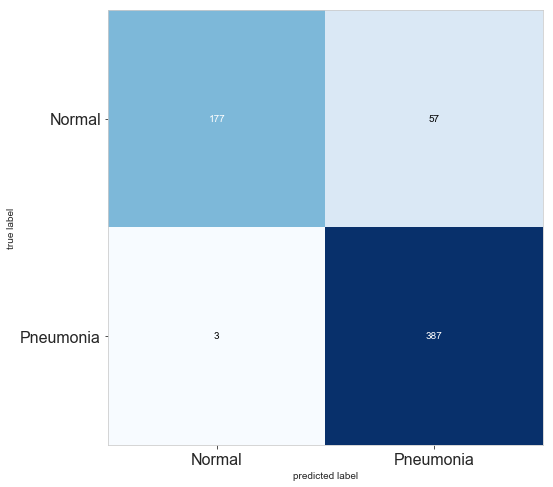

In [56]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Finally, computing the precision and recall of the model.

In [57]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.87


Nice!!! So, this model has a `99%` recall and `87%` precision.